In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Let's train the model first

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [37]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [38]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [40]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [41]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [42]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [43]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

#### Small subset

In [44]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [45]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

## Accuracy

In [46]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.7991483321504613

In [47]:
accuracy_score(y_val, y_pred >= 0.5)

0.7991483321504613

In [48]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [49]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print(f"{t:0.2f} {acc:0.3f}")

0.00 0.260
0.05 0.490
0.10 0.594
0.15 0.647
0.20 0.692
0.25 0.727
0.30 0.753
0.35 0.764
0.40 0.780
0.45 0.790
0.50 0.799
0.55 0.801
0.60 0.790
0.65 0.793
0.70 0.773
0.75 0.757
0.80 0.744
0.85 0.740
0.90 0.740
0.95 0.740
1.00 0.740


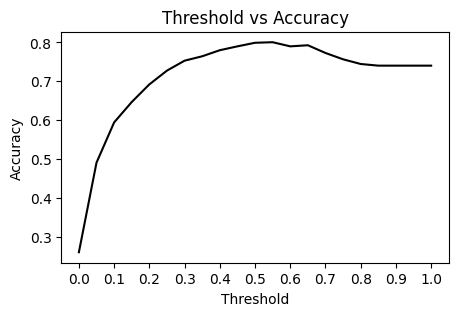

In [50]:
plt.figure(figsize=(5, 3))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [51]:
churn_small = y_pred_small >= 0.5
(churn_small == y_val).mean()

0.7693399574166075

In [52]:
accuracy_score(y_val, churn_small)

0.7693399574166075

In [53]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [54]:
accuracy_score(baseline, y_val)

0.7402413058907026

## Confusion table

In [55]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [56]:
confusion_table = np.array(
# predict:  neg            pos
    [[true_negative, false_positive],  # actual: neg
     [false_negative, true_positive]]  #         pos
)
confusion_table

array([[916, 127],
       [156, 210]])

In [57]:
confusion_table / confusion_table.sum()

array([[0.65010646, 0.09013485],
       [0.11071682, 0.14904187]])

## Precision and recall
 

In [58]:
(true_positive + true_negative) / confusion_table.sum()

0.7991483321504613

In [59]:
accuracy_score(y_val, y_pred >= 0.5)

0.7991483321504613

In [60]:
precision = true_positive / (true_positive + false_positive) # y_pred == 1
recall = true_positive / (true_positive + false_negative) # y_val == 1
precision, recall

(0.6231454005934718, 0.5737704918032787)

## ROC and AUC
**A Receiver Operating Characteristic (ROC) curve** is a graphical plot that illustrates the performance of a binary classification model at different classification thresholds. It shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at various threshold values. The ROC curve is created by plotting the TPR against the FPR at different threshold values. 

**The area under the ROC curve (AUC)** is a common metric used to evaluate the performance of a binary classification model based on its ROC curve. The AUC represents the degree or measure of separability between the positive and negative instances in the dataset, and thus reflects how well the model is able to distinguish between the two classes. An AUC of 1 represents perfect performance, while an AUC of 0.5 represents a model that performs no better than random guessing.

### TPR and FPR
The TPR, also called recall or sensitivity, is the proportion of positive instances that are correctly identified as positive by the model, while the FPR is the proportion of negative instances that are incorrectly identified as positive.

In [88]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,366,1043,0,0
10,0.1,342,548,24,495
20,0.2,310,378,56,665
30,0.3,282,264,84,779
40,0.4,250,194,116,849
50,0.5,210,127,156,916
60,0.6,148,78,218,965
70,0.7,78,32,288,1011
80,0.8,8,2,358,1041
90,0.9,0,0,366,1043


In [89]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) # y_val == 1; recall, sensitivity
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn) # y_val == 0

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,366,1043,0,0,1.000000,1.000000
10,0.1,342,548,24,495,0.934426,0.525407
20,0.2,310,378,56,665,0.846995,0.362416
30,0.3,282,264,84,779,0.770492,0.253116
40,0.4,250,194,116,849,0.683060,0.186002
50,0.5,210,127,156,916,0.573770,0.121764
60,0.6,148,78,218,965,0.404372,0.074784
70,0.7,78,32,288,1011,0.213115,0.030681
80,0.8,8,2,358,1041,0.021858,0.001918
90,0.9,0,0,366,1043,0.000000,0.000000


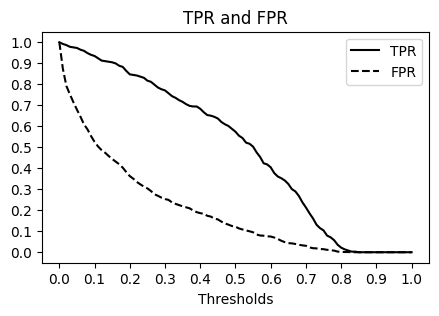

In [90]:
plt.figure(figsize=(5, 3))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Random baseline

In [91]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [92]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,366,1043,0,0,1.000000,1.000000
10,0.1,331,939,35,104,0.904372,0.900288
20,0.2,291,838,75,205,0.795082,0.803452
30,0.3,249,751,117,292,0.680328,0.720038
40,0.4,204,657,162,386,0.557377,0.629914
50,0.5,167,553,199,490,0.456284,0.530201
60,0.6,130,440,236,603,0.355191,0.421860
70,0.7,102,321,264,722,0.278689,0.307766
80,0.8,63,221,303,822,0.172131,0.211889
90,0.9,36,105,330,938,0.098361,0.100671


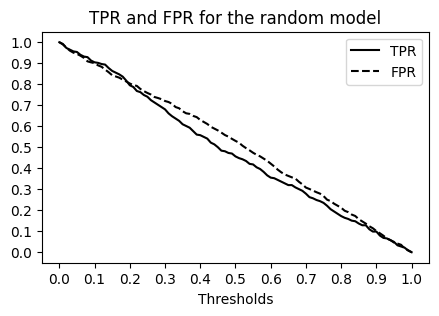

In [93]:
plt.figure(figsize=(5, 3))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

### Ideal baseline

In [94]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,366,1043,0,0,1.000000,1.000000
10,0.1,366,902,0,141,1.000000,0.864813
20,0.2,366,761,0,282,1.000000,0.729626
30,0.3,366,620,0,423,1.000000,0.594439
40,0.4,366,479,0,564,1.000000,0.459252
50,0.5,366,339,0,704,1.000000,0.325024
60,0.6,366,198,0,845,1.000000,0.189837
70,0.7,366,57,0,986,1.000000,0.054650
80,0.8,282,0,84,1043,0.770492,0.000000
90,0.9,141,0,225,1043,0.385246,0.000000


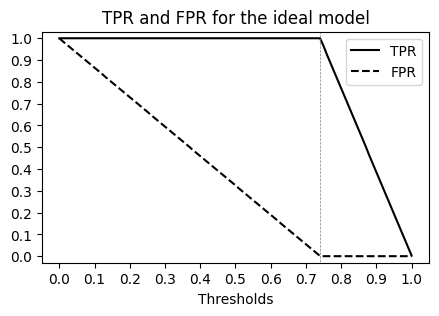

In [95]:
plt.figure(figsize=(5, 3))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

## ROC curve

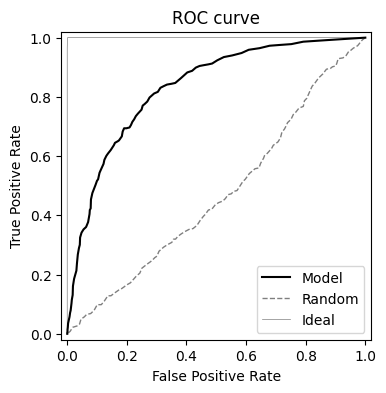

In [99]:
plt.figure(figsize=(4, 4))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

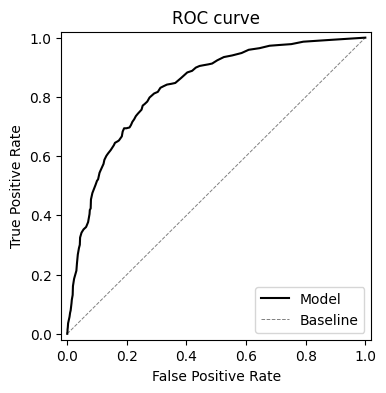

In [102]:
plt.figure(figsize=(4, 4))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5, label='Baseline')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

#### Using Scikit-Learn for plotting the ROC curve

In [103]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [104]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8305002383833939

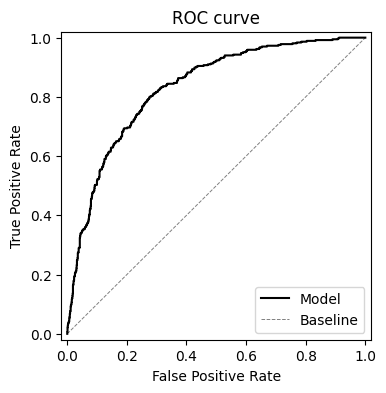

In [105]:
plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr, color='black', label='Model')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5, label='Baseline')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

#### Comparing multiple models with ROC curves

In [154]:
from sklearn.metrics import roc_auc_score

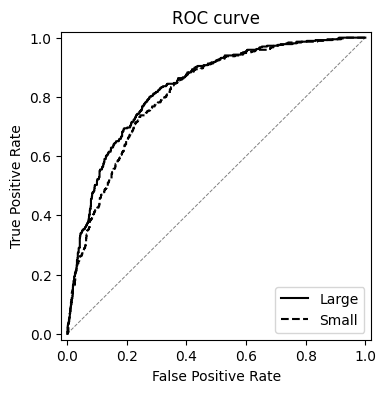

In [153]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(4, 4))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [155]:
roc_auc_score(y_val, y_pred)

0.8305002383833939

In [156]:
roc_auc_score(y_val, y_pred_small)

0.8117530871959301

#### Interpretation of AUC: Area under the ROC curve
**The area under the curve (AUC)** measures the probability that a randomly chosen positive example will have a higher score than a randomly chosen negative example. It provides insight into the ability of the model to `distinguish between positive and negative classes`, with perfect separation indicating that all positive examples have higher scores than negative examples, while overlap indicates imperfect separation.

In [107]:
auc(df_scores.fpr, df_scores.tpr)

0.8303836662842055

In [111]:
import random

pos = y_pred[y_val == 1]
neg = y_pred[y_val == 0]

n = 50000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.83044

## K-fold Cross-Validation
**Cross-Validation** is used to get a more accurate estimate of the model's performance. Instead of holding out a validation dataset and using it for evaluating the model to find the best parameter, we can split our full train dataset into multiple folds, such as 3, 5, 7, 10, and so on. Then, we use one fold for validating the model and the rest for training.

For example, if we have 10 folds, we use 9 of them for training the model and the remaining 1 fold for validation. We repeat this process 10 times, giving us 10 scores. We can then average these scores across all the folds and assess the spread between them.

In [158]:
from sklearn.model_selection import KFold

In [159]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [160]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

$$
\boxed{\ 1\ }\boxed{\ 2\ }\boxed{\ 3\ }\boxed{\ 4\ }\boxed{\ 5\ }\boxed{\ 1\ }\boxed{\ 1\ }\boxed{\ 1\ }\boxed{\ 1\ }\boxed{\ 10\ }

$$

$$

$$

In [176]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [189]:
[round(i, 3) for i in aucs]

[0.849, 0.842, 0.859, 0.833, 0.824, 0.841, 0.844, 0.822, 0.845, 0.861]

In [191]:
print("auc = {:0.3f} ± {:0.3f}".format(np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


#### Tuning the parameter C

In [192]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [200]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10, 100]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print("C={:<5} => auc = {:.3f} ± {:.3f}".format(C, np.mean(aucs), np.std(aucs)))

C=0.001 => auc = 0.825 ± 0.013
C=0.01  => auc = 0.839 ± 0.009
C=0.1   => auc = 0.841 ± 0.008
C=0.5   => auc = 0.841 ± 0.007
C=1     => auc = 0.841 ± 0.007
C=10    => auc = 0.841 ± 0.007
C=100   => auc = 0.841 ± 0.007


#### Full Retrain

In [201]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f"auc = {auc:.3}")

auc = 0.858
